In [1]:
import pandas as pd
import getpass
from sqlalchemy import create_engine
from sqlalchemy.exc import ResourceClosedError
import MySQLdb 
check = False

In [2]:
# Uzdevums:
# Nokopējiet faila make_db.sql, kas atrodās githubā, saturu, 
# atveriet mysql shell caur termināli 
# un ielīmējiet/izpildiet make_db.sql esošo kodu

# Šī ir MySQL parauga datubāze, kura ir aprakstīta šeit:
# https://www.mysqltutorial.org/mysql-sample-database.aspx

In [3]:

class MySQLConnection:
    def __init__(self,user,hostname,db):
        self.user = str(user)
        self.hostname = str(hostname)
        self.db = str(db)
        pword = getpass.getpass("Enter password for user {}".format(user))
        # self.cnx = mysql.connector.connect(host=self.hostname,user=self.user, password=pword,database=self.db)
        self.engine = create_engine("mysql+mysqlconnector://{}:{}@{}/{}".format(user,pword,hostname,db))
        self.cnx = self.engine.connect()
    
    def write_to_db(self, df, table_name):
        try:
            df.to_sql(table_name,con = self.cnx,if_exists='fail',index=False)
        except Exception as e:
            print("\n SQL Write error with: ")
            print(df,"\n", e)
    
    def query(self,q):
        try:
            res = pd.read_sql(q,self.cnx)
            return res
        except ResourceClosedError:
            print("Query success, nothing was returned")

In [3]:
sql = MySQLConnection('ubuntu','localhost','dati')

Enter password for user ubuntu········


In [4]:
sql.query("select * from orders")

,order_id,order_date,amount,customer_id
0,1,07/04/1776,$234.56,1
1,2,03/14/1760,$78.50,3
2,3,05/23/1784,$124.00,2
3,4,09/03/1790,$65.50,3
4,5,07/21/1795,$25.50,10
5,6,11/27/1787,$14.40,9


In [5]:
sql.query("select * from customers")

,customer_id,first_name,last_name,email,address,city,state,zipcode
0,1,George,Washington,gwashington@usa.gov,3200 Mt Vernon Hwy,Mount Vernon,VA,22121
1,2,John,Adams,jadams@usa.gov,1250 Hancock St,Quincy,MA,2169
2,3,Thomas,Jefferson,tjefferson@usa.gov,931 Thomas Jefferson Pkwy,Charlottesville,VA,22902
3,4,James,Madison,jmadison@usa.gov,11350 Constitution Hwy,Orange,VA,22960
4,5,James,Monroe,jmonroe@usa.gov,2050 James Monroe Parkway,Charlottesville,VA,22902


In [12]:
# 4. Katrā pilsētā ir tieši viens kurjers, cik piegāžu būs jāveic katram kurjeram?
# sql.query("SELECT * from orders")

# No sākuma, tabulas apvienosim un rezultātu ievietosim jaunā tabulā
q = """
create table join_rezultats as 
select 
    order_id, 
    city
from 
    customers join orders on 
    customers.customer_id = orders.order_id
"""
sql.query(q)

Query success, nothing was returned


In [7]:
sql.query("select * from join_rezultats order by city")

,order_id,city
0,3,Charlottesville
1,5,Charlottesville
2,1,Mount Vernon
3,4,Orange
4,2,Quincy


In [ ]:
# Mums bija jāizdara vairāki selekti, lai izveidotu jaunas 'tabulas'. 
# Tik, cik ir pilsētu.
# Un tad jāsaskaita cik ierakstu / piegāžu ir katrā šajā 'tabulā'

# Šo darbību var automatizēt izmantojot GROUP BY

# GROUP BY  
GROUP BY veic grupēšanu pa kādas kolonnas unikālajām vērtībām un aprēķina kādu 'kopsavilkuma' funkciju katrai šai grupai.  

Piemēram, ja mums ir tabula, kurā ir 15 rindiņas un  3 kolonnas a, b un c, kur c kolonnā ir divas unikālas vērtības, tad GROUP BY pēc c kolonnas, mums izveidos divas grupas. Viena katrai unikālajai c vērtībai. Uz šīm grupām tad obligāti ir jāuzliek kāda kopsavilkuma funkcija.  

Lietojamās kopsavilkuma funkcijas ir sekojošās:  
* COUNT  
* SUM  
* AVG  
* MIN  
* MAX  
Atkarībā no specifiskās SQL versijas, ko lietojat, šajā sarakstā var arī būt vēl kādas funkcijas

In [8]:
q2 = """
select 
    city,
    count(*) as piegazu_skaits
from 
    join_rezultats
group by
    city
"""
sql.query(q2)

,city,piegazu_skaits
0,Charlottesville,2
1,Mount Vernon,1
2,Orange,1
3,Quincy,1


In [4]:
# Uzdevums:
# 1. Resetojiet kerneli, lai izveidotu jaunu sql objektu, iestādiet datubāzi uz classicmodels. 
# Visi sekojošie uzdevumi būs ar datubāzi classicmodels un ir jāpēta datubāzes modelis, lai tos izdomātu.

sql = MySQLConnection('ubuntu','localhost','classicmodels')

# 2. Izpētiet datubāzes classicmodels shēmu. 
# Saskaitiet cik piegāžu ir katrā pilsētā, 
# izmantojot tabulas customers un orders no datubāzes classicmodels.

Enter password for user ubuntu········


In [11]:
uzd1 = """
select 
    count(*) as number_of_orders, 
    city
from 
    customers join orders on 
    customers.customernumber = orders.customernumber
group by
    city
order by 
    number_of_orders desc 
limit 
    20
"""
# sql.query(uzd1)

In [15]:
# Uzdevums:
# Saskaitiet cik ir produktu līniju un cik katrā produktu līnijā ir unikālu produktu.
# sql.query("select count(distinct productline) from products")

prd = """
select 
    productline,
    count(productcode) 
from 
    products
group by
    productline
"""
sql.query(prd)

,productline,count(productcode)
0,Classic Cars,38
1,Motorcycles,13
2,Planes,12
3,Ships,9
4,Trains,3
5,Trucks and Buses,11
6,Vintage Cars,24


In [18]:
# Uzdevums:
# Aprēķiniet cik daudz ienākumu ir no katras produktu līnijas
sql.query("create table orderdetails_w_income as select *, priceeach*quantityordered as income from orderdetails")

Query success, nothing was returned


In [19]:
sql.query("select * from orderdetails_w_income limit 10")

,orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber,income
0,10100,S18_1749,30,136.00,3,4080.00
1,10100,S18_2248,50,55.09,2,2754.50
2,10100,S18_4409,22,75.46,4,1660.12
3,10100,S24_3969,49,35.29,1,1729.21
4,10101,S18_2325,25,108.06,4,2701.50
5,10101,S18_2795,26,167.06,1,4343.56
6,10101,S24_1937,45,32.53,3,1463.85
7,10101,S24_2022,46,44.35,2,2040.10
8,10102,S18_1342,39,95.55,2,3726.45
9,10102,S18_1367,41,43.13,1,1768.33


In [25]:
some_q = """
select
    productline,
    sum(income) as ienakumi
from 
    orderdetails_w_income join products on 
    orderdetails_w_income.productcode = products.productcode
group by
    productline
order by
    ienakumi desc
"""
sql.query(some_q)

,productline,ienakumi
0,Classic Cars,3853922.49
1,Vintage Cars,1797559.63
2,Motorcycles,1121426.12
3,Trucks and Buses,1024113.57
4,Planes,954637.54
5,Ships,663998.34
6,Trains,188532.92


In [ ]:
#Uzdevums:
# Aprēķiniet cik ir ienākumu no katras pilsētas

# Vairāku līmeņu SELECT  
Bieži rodās situācijas, kur mēs nevaram iegut nepieciešamos datus apvienojot tikai divas tabulas. 

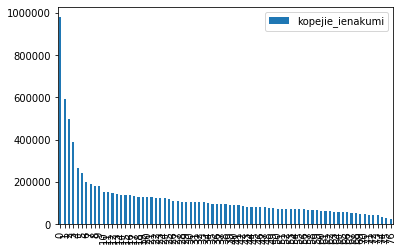

In [38]:
q3 = """
select 
    sum(income) as kopejie_ienakumi,
    city
from 
    customers join 
    (
    select
        orders.customernumber,
        orderdetails_w_income.income
    from 
        orderdetails_w_income join orders on
        orderdetails_w_income.ordernumber = orders.ordernumber
    ) pasutijumu_ienakumi on 
    customers.customernumber = pasutijumu_ienakumi.customernumber
group by
    city
order by 
    kopejie_ienakumi desc
"""


# test_q = """
# select
#     customernumber,
#     income
# from 
#     orderdetails_w_income join orders on
#     orderdetails_w_income.ordernumber = orders.ordernumber
# """
sql.query(q3).plot.bar()

Vispārīga sintakse iekšējo joinu veidošanai:  


In [ ]:
"""
SELECT
    kolonna1,
    kolonna2
FROM 
    areja_joina_tabula <join tips> join 
    (
        
    <
    SELECT statements un/vai joins, 
    kas atgriež tabulu, kura satur indeksu, 
    ko var sasaistīt ar tabulu areja_join_tabula 
    >

    ) iekseja_join_tabula on 
    areja_join_tabula.indeksa_kolonna = iekseja_join_tabula.indeksa_kolonna_velams_nosaukta_citadi
"""

Praktiski padomi strādājot ar vairākiem joiniem:  
* Izmantojiet aliasus
* Vienmēr iztestējiet iekšējo joinu kā pirmo. Pārbaudiet vai kolonnas ir nosauktas, vai vērtības šķiet saprātīgas.


In [ ]:
# Uzdevums: Saskaitiet cik pasūtījumu ir katrā pilsētā.
# Padoms: to var izdarīt ļoti minimāli modificējot q3_grouped vaicājuma kodu